# Import Libraries

In [41]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from skimage import io
import torch.nn.functional as f

# Load dataset

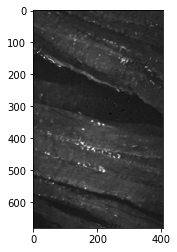

In [2]:
# loading dataset
data_dir = '/home/jessew/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
filenames = os.listdir(data_dir)
# print(filenames)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    plt.imshow(img[:,:,5], cmap='gray')
#     plt.show()
    img_stack.append(img)

In [3]:
# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
print(img_stack.shape)

(25, 681, 406, 9)


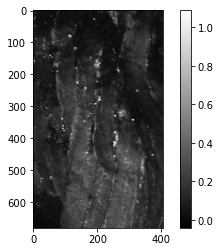

In [4]:
# choose a slice and show
plt.imshow(img_stack[2,:,:,5], cmap = 'gray')
plt.colorbar()
plt.show()

In [5]:
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

img width = 681, img height = 406, img channels = 9


# Define model

In [57]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 3, kernel_size=1, stride=1),
            Sigmoid()
        )
        
        """The spectral autoencoder has a bottleneck in the number of channels instead of upsampling and downsampling layers"""
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, nch, kernel_size=1, stride=1),            
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.cnn_spectral_layers(x)
        return x
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y

In [58]:
# instantiate the model by calling the function
model = Net()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [59]:
# define loss function
criterion = nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
# set the model training device
"""cuda:0 for GPU 0, cuda:1 for GPU1, cpu for CPU"""
device = 'cuda:1'
print(device)
model.to(device) # load the model in the training device

cuda:1


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [10]:
# prepare the input data before training
img_stack = torch.tensor(img_stack)
print(img_stack.shape)
img_stack = img_stack.to(device)

torch.Size([25, 681, 406, 9])


In [11]:
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    return img

# Experiment with variance ordering loss

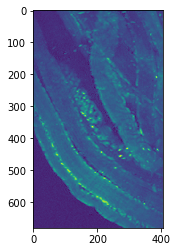

tensor(0.0004, device='cuda:0')

In [30]:
img=img_stack[1,:,:,3].detach().cpu().numpy()
plt.imshow(img)
plt.show()

meansq(img_stack[1,:,:,0])

In [27]:
def meansq(x):
    return torch.mean(x**2)

# Train model

  0%|          | 1/200 [00:00<01:03,  3.12it/s]

Epoch: 1 	Training Loss: 0.105021


  1%|          | 2/200 [00:00<01:02,  3.15it/s]

Epoch: 2 	Training Loss: 0.066735


  2%|▏         | 3/200 [00:00<01:02,  3.16it/s]

Epoch: 3 	Training Loss: 0.064880


  2%|▏         | 4/200 [00:01<01:01,  3.16it/s]

Epoch: 4 	Training Loss: 0.064652


  2%|▎         | 5/200 [00:01<01:01,  3.17it/s]

Epoch: 5 	Training Loss: 0.064538


  3%|▎         | 6/200 [00:01<01:01,  3.17it/s]

Epoch: 6 	Training Loss: 0.064258


  4%|▎         | 7/200 [00:02<01:00,  3.17it/s]

Epoch: 7 	Training Loss: 0.061898


  4%|▍         | 8/200 [00:02<01:00,  3.17it/s]

Epoch: 8 	Training Loss: 0.053116


  4%|▍         | 9/200 [00:02<01:00,  3.17it/s]

Epoch: 9 	Training Loss: 0.047481


  5%|▌         | 10/200 [00:03<00:59,  3.17it/s]

Epoch: 10 	Training Loss: 0.030076


  6%|▌         | 11/200 [00:03<00:59,  3.17it/s]

Epoch: 11 	Training Loss: 0.028015


  6%|▌         | 12/200 [00:03<00:59,  3.17it/s]

Epoch: 12 	Training Loss: 0.020341


  6%|▋         | 13/200 [00:04<00:59,  3.17it/s]

Epoch: 13 	Training Loss: 0.020869


  7%|▋         | 14/200 [00:04<00:58,  3.17it/s]

Epoch: 14 	Training Loss: 0.018761


  8%|▊         | 15/200 [00:04<00:58,  3.17it/s]

Epoch: 15 	Training Loss: 0.016638


  8%|▊         | 16/200 [00:05<00:58,  3.17it/s]

Epoch: 16 	Training Loss: 0.015786


  8%|▊         | 17/200 [00:05<00:57,  3.17it/s]

Epoch: 17 	Training Loss: 0.014923


  9%|▉         | 18/200 [00:05<00:57,  3.17it/s]

Epoch: 18 	Training Loss: 0.018557


 10%|▉         | 19/200 [00:06<00:57,  3.16it/s]

Epoch: 19 	Training Loss: 0.015375


 10%|█         | 20/200 [00:06<00:56,  3.17it/s]

Epoch: 20 	Training Loss: 0.014446


 10%|█         | 21/200 [00:06<00:56,  3.17it/s]

Epoch: 21 	Training Loss: 0.014038


 11%|█         | 22/200 [00:06<00:56,  3.16it/s]

Epoch: 22 	Training Loss: 0.013610


 12%|█▏        | 23/200 [00:07<00:55,  3.17it/s]

Epoch: 23 	Training Loss: 0.013640


 12%|█▏        | 24/200 [00:07<00:55,  3.17it/s]

Epoch: 24 	Training Loss: 0.013897


 12%|█▎        | 25/200 [00:07<00:55,  3.17it/s]

Epoch: 25 	Training Loss: 0.013355


 13%|█▎        | 26/200 [00:08<00:54,  3.16it/s]

Epoch: 26 	Training Loss: 0.013430


 14%|█▎        | 27/200 [00:08<00:54,  3.16it/s]

Epoch: 27 	Training Loss: 0.013237


 14%|█▍        | 28/200 [00:08<00:54,  3.16it/s]

Epoch: 28 	Training Loss: 0.013139


 14%|█▍        | 29/200 [00:09<00:54,  3.16it/s]

Epoch: 29 	Training Loss: 0.013029


 15%|█▌        | 30/200 [00:09<00:53,  3.16it/s]

Epoch: 30 	Training Loss: 0.012904


 16%|█▌        | 31/200 [00:09<00:53,  3.16it/s]

Epoch: 31 	Training Loss: 0.012753


 16%|█▌        | 32/200 [00:10<00:53,  3.16it/s]

Epoch: 32 	Training Loss: 0.012668


 16%|█▋        | 33/200 [00:10<00:52,  3.16it/s]

Epoch: 33 	Training Loss: 0.012539


 17%|█▋        | 34/200 [00:10<00:52,  3.16it/s]

Epoch: 34 	Training Loss: 0.012392


 18%|█▊        | 35/200 [00:11<00:52,  3.16it/s]

Epoch: 35 	Training Loss: 0.012199


 18%|█▊        | 36/200 [00:11<00:51,  3.16it/s]

Epoch: 36 	Training Loss: 0.011932


 18%|█▊        | 37/200 [00:11<00:51,  3.16it/s]

Epoch: 37 	Training Loss: 0.011548


 19%|█▉        | 38/200 [00:12<00:51,  3.16it/s]

Epoch: 38 	Training Loss: 0.010590


 20%|█▉        | 39/200 [00:12<00:50,  3.16it/s]

Epoch: 39 	Training Loss: 0.009888


 20%|██        | 40/200 [00:12<00:50,  3.16it/s]

Epoch: 40 	Training Loss: 0.012296


 20%|██        | 41/200 [00:12<00:50,  3.16it/s]

Epoch: 41 	Training Loss: 0.010686


 21%|██        | 42/200 [00:13<00:50,  3.16it/s]

Epoch: 42 	Training Loss: 0.009250


 22%|██▏       | 43/200 [00:13<00:49,  3.16it/s]

Epoch: 43 	Training Loss: 0.009018


 22%|██▏       | 44/200 [00:13<00:49,  3.16it/s]

Epoch: 44 	Training Loss: 0.008531


 22%|██▎       | 45/200 [00:14<00:49,  3.16it/s]

Epoch: 45 	Training Loss: 0.008870


 23%|██▎       | 46/200 [00:14<00:48,  3.16it/s]

Epoch: 46 	Training Loss: 0.009024


 24%|██▎       | 47/200 [00:14<00:48,  3.16it/s]

Epoch: 47 	Training Loss: 0.008665


 24%|██▍       | 48/200 [00:15<00:48,  3.15it/s]

Epoch: 48 	Training Loss: 0.008215


 24%|██▍       | 49/200 [00:15<00:47,  3.15it/s]

Epoch: 49 	Training Loss: 0.008113
Epoch: 50 	Training Loss: 0.008516


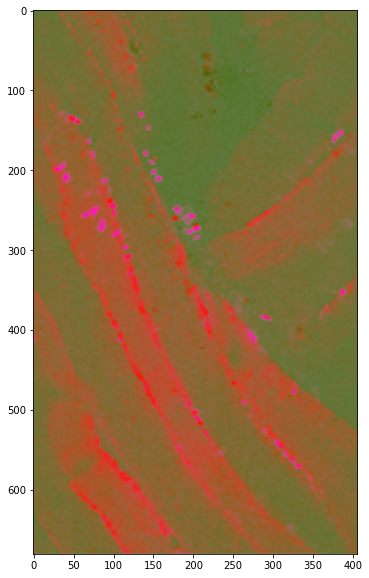

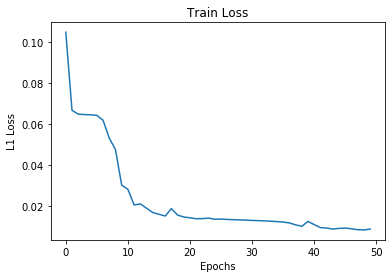

 26%|██▌       | 51/200 [00:16<00:56,  2.66it/s]

Epoch: 51 	Training Loss: 0.008606


 26%|██▌       | 52/200 [00:16<00:53,  2.79it/s]

Epoch: 52 	Training Loss: 0.008270


 26%|██▋       | 53/200 [00:17<00:50,  2.89it/s]

Epoch: 53 	Training Loss: 0.008007


 27%|██▋       | 54/200 [00:17<00:49,  2.96it/s]

Epoch: 54 	Training Loss: 0.007753


 28%|██▊       | 55/200 [00:17<00:48,  3.02it/s]

Epoch: 55 	Training Loss: 0.007450


 28%|██▊       | 56/200 [00:17<00:47,  3.06it/s]

Epoch: 56 	Training Loss: 0.007363


 28%|██▊       | 57/200 [00:18<00:46,  3.08it/s]

Epoch: 57 	Training Loss: 0.007402


 29%|██▉       | 58/200 [00:18<00:45,  3.10it/s]

Epoch: 58 	Training Loss: 0.007535


 30%|██▉       | 59/200 [00:18<00:45,  3.12it/s]

Epoch: 59 	Training Loss: 0.007398


 30%|███       | 60/200 [00:19<00:44,  3.13it/s]

Epoch: 60 	Training Loss: 0.007264


 30%|███       | 61/200 [00:19<00:44,  3.13it/s]

Epoch: 61 	Training Loss: 0.007242


 31%|███       | 62/200 [00:19<00:43,  3.14it/s]

Epoch: 62 	Training Loss: 0.007562


 32%|███▏      | 63/200 [00:20<00:43,  3.14it/s]

Epoch: 63 	Training Loss: 0.008215


 32%|███▏      | 64/200 [00:20<00:43,  3.14it/s]

Epoch: 64 	Training Loss: 0.008159


 32%|███▎      | 65/200 [00:20<00:42,  3.15it/s]

Epoch: 65 	Training Loss: 0.007367


 33%|███▎      | 66/200 [00:21<00:42,  3.15it/s]

Epoch: 66 	Training Loss: 0.007792


 34%|███▎      | 67/200 [00:21<00:42,  3.15it/s]

Epoch: 67 	Training Loss: 0.008053


 34%|███▍      | 68/200 [00:21<00:41,  3.15it/s]

Epoch: 68 	Training Loss: 0.007293


 34%|███▍      | 69/200 [00:22<00:41,  3.15it/s]

Epoch: 69 	Training Loss: 0.007393


 35%|███▌      | 70/200 [00:22<00:41,  3.15it/s]

Epoch: 70 	Training Loss: 0.007289


 36%|███▌      | 71/200 [00:22<00:40,  3.15it/s]

Epoch: 71 	Training Loss: 0.007235


 36%|███▌      | 72/200 [00:23<00:40,  3.15it/s]

Epoch: 72 	Training Loss: 0.007599


 36%|███▋      | 73/200 [00:23<00:40,  3.15it/s]

Epoch: 73 	Training Loss: 0.007532


 37%|███▋      | 74/200 [00:23<00:40,  3.15it/s]

Epoch: 74 	Training Loss: 0.007195


 38%|███▊      | 75/200 [00:24<00:39,  3.15it/s]

Epoch: 75 	Training Loss: 0.007262


 38%|███▊      | 76/200 [00:24<00:39,  3.15it/s]

Epoch: 76 	Training Loss: 0.007527


 38%|███▊      | 77/200 [00:24<00:39,  3.15it/s]

Epoch: 77 	Training Loss: 0.007238


 39%|███▉      | 78/200 [00:24<00:38,  3.15it/s]

Epoch: 78 	Training Loss: 0.007347


 40%|███▉      | 79/200 [00:25<00:38,  3.15it/s]

Epoch: 79 	Training Loss: 0.007399


 40%|████      | 80/200 [00:25<00:38,  3.15it/s]

Epoch: 80 	Training Loss: 0.007198


 40%|████      | 81/200 [00:25<00:37,  3.15it/s]

Epoch: 81 	Training Loss: 0.007408


 41%|████      | 82/200 [00:26<00:37,  3.15it/s]

Epoch: 82 	Training Loss: 0.007301


 42%|████▏     | 83/200 [00:26<00:37,  3.15it/s]

Epoch: 83 	Training Loss: 0.007752


 42%|████▏     | 84/200 [00:26<00:36,  3.15it/s]

Epoch: 84 	Training Loss: 0.007844


 42%|████▎     | 85/200 [00:27<00:36,  3.15it/s]

Epoch: 85 	Training Loss: 0.007316


 43%|████▎     | 86/200 [00:27<00:36,  3.15it/s]

Epoch: 86 	Training Loss: 0.007081


 44%|████▎     | 87/200 [00:27<00:35,  3.15it/s]

Epoch: 87 	Training Loss: 0.007383


 44%|████▍     | 88/200 [00:28<00:35,  3.15it/s]

Epoch: 88 	Training Loss: 0.007329


 44%|████▍     | 89/200 [00:28<00:35,  3.14it/s]

Epoch: 89 	Training Loss: 0.007073


 45%|████▌     | 90/200 [00:28<00:34,  3.14it/s]

Epoch: 90 	Training Loss: 0.007036


 46%|████▌     | 91/200 [00:29<00:34,  3.14it/s]

Epoch: 91 	Training Loss: 0.007460


 46%|████▌     | 92/200 [00:29<00:34,  3.14it/s]

Epoch: 92 	Training Loss: 0.007384


 46%|████▋     | 93/200 [00:29<00:34,  3.14it/s]

Epoch: 93 	Training Loss: 0.007090


 47%|████▋     | 94/200 [00:30<00:33,  3.14it/s]

Epoch: 94 	Training Loss: 0.007322


 48%|████▊     | 95/200 [00:30<00:33,  3.14it/s]

Epoch: 95 	Training Loss: 0.007648


 48%|████▊     | 96/200 [00:30<00:33,  3.14it/s]

Epoch: 96 	Training Loss: 0.007324


 48%|████▊     | 97/200 [00:31<00:32,  3.14it/s]

Epoch: 97 	Training Loss: 0.007007


 49%|████▉     | 98/200 [00:31<00:32,  3.14it/s]

Epoch: 98 	Training Loss: 0.006993


 50%|████▉     | 99/200 [00:31<00:32,  3.14it/s]

Epoch: 99 	Training Loss: 0.007196
Epoch: 100 	Training Loss: 0.007139


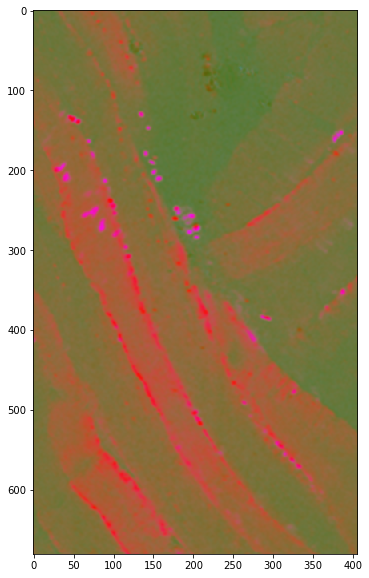

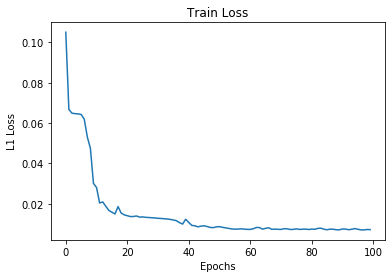

 50%|█████     | 101/200 [00:32<00:37,  2.65it/s]

Epoch: 101 	Training Loss: 0.007260


 51%|█████     | 102/200 [00:32<00:35,  2.78it/s]

Epoch: 102 	Training Loss: 0.007066


 52%|█████▏    | 103/200 [00:33<00:33,  2.88it/s]

Epoch: 103 	Training Loss: 0.006972


 52%|█████▏    | 104/200 [00:33<00:32,  2.95it/s]

Epoch: 104 	Training Loss: 0.007187


 52%|█████▎    | 105/200 [00:33<00:31,  3.01it/s]

Epoch: 105 	Training Loss: 0.007461


 53%|█████▎    | 106/200 [00:34<00:30,  3.05it/s]

Epoch: 106 	Training Loss: 0.007777


 54%|█████▎    | 107/200 [00:34<00:30,  3.07it/s]

Epoch: 107 	Training Loss: 0.007509


 54%|█████▍    | 108/200 [00:34<00:29,  3.09it/s]

Epoch: 108 	Training Loss: 0.007156


 55%|█████▍    | 109/200 [00:35<00:29,  3.11it/s]

Epoch: 109 	Training Loss: 0.007465


 55%|█████▌    | 110/200 [00:35<00:28,  3.12it/s]

Epoch: 110 	Training Loss: 0.007592


 56%|█████▌    | 111/200 [00:35<00:28,  3.12it/s]

Epoch: 111 	Training Loss: 0.007151


 56%|█████▌    | 112/200 [00:36<00:28,  3.13it/s]

Epoch: 112 	Training Loss: 0.006999


 56%|█████▋    | 113/200 [00:36<00:27,  3.13it/s]

Epoch: 113 	Training Loss: 0.006967


 57%|█████▋    | 114/200 [00:36<00:27,  3.13it/s]

Epoch: 114 	Training Loss: 0.007081


 57%|█████▊    | 115/200 [00:37<00:27,  3.14it/s]

Epoch: 115 	Training Loss: 0.007389


 58%|█████▊    | 116/200 [00:37<00:26,  3.14it/s]

Epoch: 116 	Training Loss: 0.007590


 58%|█████▊    | 117/200 [00:37<00:26,  3.14it/s]

Epoch: 117 	Training Loss: 0.007190


 59%|█████▉    | 118/200 [00:37<00:26,  3.14it/s]

Epoch: 118 	Training Loss: 0.007078


 60%|█████▉    | 119/200 [00:38<00:25,  3.14it/s]

Epoch: 119 	Training Loss: 0.007015


 60%|██████    | 120/200 [00:38<00:25,  3.14it/s]

Epoch: 120 	Training Loss: 0.007360


 60%|██████    | 121/200 [00:38<00:25,  3.14it/s]

Epoch: 121 	Training Loss: 0.007343


 61%|██████    | 122/200 [00:39<00:24,  3.14it/s]

Epoch: 122 	Training Loss: 0.007030


 62%|██████▏   | 123/200 [00:39<00:24,  3.14it/s]

Epoch: 123 	Training Loss: 0.007244


 62%|██████▏   | 124/200 [00:39<00:24,  3.14it/s]

Epoch: 124 	Training Loss: 0.007034


 62%|██████▎   | 125/200 [00:40<00:23,  3.14it/s]

Epoch: 125 	Training Loss: 0.007005


 63%|██████▎   | 126/200 [00:40<00:23,  3.14it/s]

Epoch: 126 	Training Loss: 0.007399


 64%|██████▎   | 127/200 [00:40<00:23,  3.14it/s]

Epoch: 127 	Training Loss: 0.007593


 64%|██████▍   | 128/200 [00:41<00:22,  3.14it/s]

Epoch: 128 	Training Loss: 0.007169


 64%|██████▍   | 129/200 [00:41<00:22,  3.14it/s]

Epoch: 129 	Training Loss: 0.007188


 65%|██████▌   | 130/200 [00:41<00:22,  3.14it/s]

Epoch: 130 	Training Loss: 0.007273


 66%|██████▌   | 131/200 [00:42<00:21,  3.14it/s]

Epoch: 131 	Training Loss: 0.007412


 66%|██████▌   | 132/200 [00:42<00:21,  3.14it/s]

Epoch: 132 	Training Loss: 0.007294


 66%|██████▋   | 133/200 [00:42<00:21,  3.14it/s]

Epoch: 133 	Training Loss: 0.007141


 67%|██████▋   | 134/200 [00:43<00:21,  3.14it/s]

Epoch: 134 	Training Loss: 0.007027


 68%|██████▊   | 135/200 [00:43<00:20,  3.14it/s]

Epoch: 135 	Training Loss: 0.006939


 68%|██████▊   | 136/200 [00:43<00:20,  3.14it/s]

Epoch: 136 	Training Loss: 0.006920


 68%|██████▊   | 137/200 [00:44<00:20,  3.14it/s]

Epoch: 137 	Training Loss: 0.006958


 69%|██████▉   | 138/200 [00:44<00:19,  3.14it/s]

Epoch: 138 	Training Loss: 0.007009


 70%|██████▉   | 139/200 [00:44<00:19,  3.14it/s]

Epoch: 139 	Training Loss: 0.007359


 70%|███████   | 140/200 [00:45<00:19,  3.14it/s]

Epoch: 140 	Training Loss: 0.007273


 70%|███████   | 141/200 [00:45<00:18,  3.14it/s]

Epoch: 141 	Training Loss: 0.007115


 71%|███████   | 142/200 [00:45<00:18,  3.14it/s]

Epoch: 142 	Training Loss: 0.006997


 72%|███████▏  | 143/200 [00:45<00:18,  3.14it/s]

Epoch: 143 	Training Loss: 0.007535


 72%|███████▏  | 144/200 [00:46<00:17,  3.14it/s]

Epoch: 144 	Training Loss: 0.007591


 72%|███████▎  | 145/200 [00:46<00:17,  3.14it/s]

Epoch: 145 	Training Loss: 0.007361


 73%|███████▎  | 146/200 [00:46<00:17,  3.14it/s]

Epoch: 146 	Training Loss: 0.007358


 74%|███████▎  | 147/200 [00:47<00:16,  3.14it/s]

Epoch: 147 	Training Loss: 0.006948


 74%|███████▍  | 148/200 [00:47<00:16,  3.14it/s]

Epoch: 148 	Training Loss: 0.007126


 74%|███████▍  | 149/200 [00:47<00:16,  3.13it/s]

Epoch: 149 	Training Loss: 0.007170
Epoch: 150 	Training Loss: 0.007060


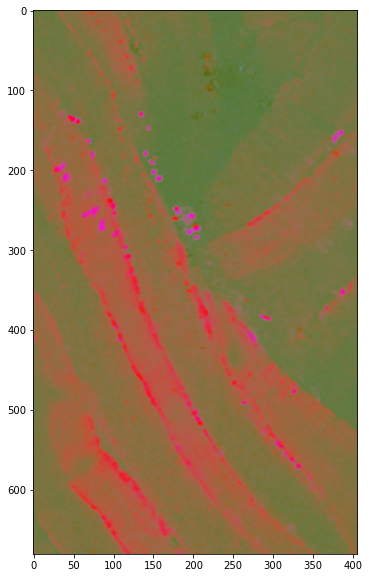

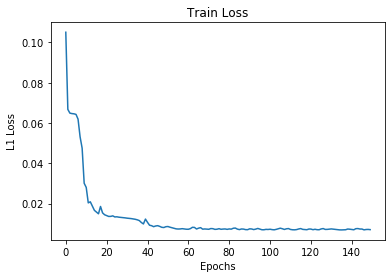

 76%|███████▌  | 151/200 [00:48<00:18,  2.63it/s]

Epoch: 151 	Training Loss: 0.007169


 76%|███████▌  | 152/200 [00:49<00:17,  2.76it/s]

Epoch: 152 	Training Loss: 0.007192


 76%|███████▋  | 153/200 [00:49<00:16,  2.86it/s]

Epoch: 153 	Training Loss: 0.007276


 77%|███████▋  | 154/200 [00:49<00:15,  2.94it/s]

Epoch: 154 	Training Loss: 0.007275


 78%|███████▊  | 155/200 [00:50<00:15,  3.00it/s]

Epoch: 155 	Training Loss: 0.007324


 78%|███████▊  | 156/200 [00:50<00:14,  3.04it/s]

Epoch: 156 	Training Loss: 0.007243


 78%|███████▊  | 157/200 [00:50<00:14,  3.06it/s]

Epoch: 157 	Training Loss: 0.006933


 79%|███████▉  | 158/200 [00:51<00:13,  3.08it/s]

Epoch: 158 	Training Loss: 0.006987


 80%|███████▉  | 159/200 [00:51<00:13,  3.10it/s]

Epoch: 159 	Training Loss: 0.006985


 80%|████████  | 160/200 [00:51<00:12,  3.11it/s]

Epoch: 160 	Training Loss: 0.007091


 80%|████████  | 161/200 [00:51<00:12,  3.11it/s]

Epoch: 161 	Training Loss: 0.007429


 81%|████████  | 162/200 [00:52<00:12,  3.12it/s]

Epoch: 162 	Training Loss: 0.007274


 82%|████████▏ | 163/200 [00:52<00:11,  3.12it/s]

Epoch: 163 	Training Loss: 0.006926


 82%|████████▏ | 164/200 [00:52<00:11,  3.12it/s]

Epoch: 164 	Training Loss: 0.006862


 82%|████████▎ | 165/200 [00:53<00:11,  3.13it/s]

Epoch: 165 	Training Loss: 0.006986


 83%|████████▎ | 166/200 [00:53<00:10,  3.13it/s]

Epoch: 166 	Training Loss: 0.007179


 84%|████████▎ | 167/200 [00:53<00:10,  3.13it/s]

Epoch: 167 	Training Loss: 0.007241


 84%|████████▍ | 168/200 [00:54<00:10,  3.13it/s]

Epoch: 168 	Training Loss: 0.007436


 84%|████████▍ | 169/200 [00:54<00:09,  3.13it/s]

Epoch: 169 	Training Loss: 0.007422


 85%|████████▌ | 170/200 [00:54<00:09,  3.13it/s]

Epoch: 170 	Training Loss: 0.006965


 86%|████████▌ | 171/200 [00:55<00:09,  3.13it/s]

Epoch: 171 	Training Loss: 0.006930


 86%|████████▌ | 172/200 [00:55<00:08,  3.13it/s]

Epoch: 172 	Training Loss: 0.006927


 86%|████████▋ | 173/200 [00:55<00:08,  3.13it/s]

Epoch: 173 	Training Loss: 0.006942


 87%|████████▋ | 174/200 [00:56<00:08,  3.13it/s]

Epoch: 174 	Training Loss: 0.006980


 88%|████████▊ | 175/200 [00:56<00:07,  3.13it/s]

Epoch: 175 	Training Loss: 0.006878


 88%|████████▊ | 176/200 [00:56<00:07,  3.13it/s]

Epoch: 176 	Training Loss: 0.006856


 88%|████████▊ | 177/200 [00:57<00:07,  3.13it/s]

Epoch: 177 	Training Loss: 0.007141


 89%|████████▉ | 178/200 [00:57<00:07,  3.13it/s]

Epoch: 178 	Training Loss: 0.006987


 90%|████████▉ | 179/200 [00:57<00:06,  3.13it/s]

Epoch: 179 	Training Loss: 0.007001


 90%|█████████ | 180/200 [00:58<00:06,  3.13it/s]

Epoch: 180 	Training Loss: 0.007149


 90%|█████████ | 181/200 [00:58<00:06,  3.13it/s]

Epoch: 181 	Training Loss: 0.006976


 91%|█████████ | 182/200 [00:58<00:05,  3.13it/s]

Epoch: 182 	Training Loss: 0.007344


 92%|█████████▏| 183/200 [00:59<00:05,  3.13it/s]

Epoch: 183 	Training Loss: 0.007458


 92%|█████████▏| 184/200 [00:59<00:05,  3.13it/s]

Epoch: 184 	Training Loss: 0.007221


 92%|█████████▎| 185/200 [00:59<00:04,  3.13it/s]

Epoch: 185 	Training Loss: 0.007141


 93%|█████████▎| 186/200 [00:59<00:04,  3.13it/s]

Epoch: 186 	Training Loss: 0.007046


 94%|█████████▎| 187/200 [01:00<00:04,  3.13it/s]

Epoch: 187 	Training Loss: 0.006901


 94%|█████████▍| 188/200 [01:00<00:03,  3.13it/s]

Epoch: 188 	Training Loss: 0.006915


 94%|█████████▍| 189/200 [01:00<00:03,  3.13it/s]

Epoch: 189 	Training Loss: 0.007280


 95%|█████████▌| 190/200 [01:01<00:03,  3.13it/s]

Epoch: 190 	Training Loss: 0.007401


 96%|█████████▌| 191/200 [01:01<00:02,  3.13it/s]

Epoch: 191 	Training Loss: 0.006961


 96%|█████████▌| 192/200 [01:01<00:02,  3.13it/s]

Epoch: 192 	Training Loss: 0.006916


 96%|█████████▋| 193/200 [01:02<00:02,  3.13it/s]

Epoch: 193 	Training Loss: 0.006846


 97%|█████████▋| 194/200 [01:02<00:01,  3.13it/s]

Epoch: 194 	Training Loss: 0.006834


 98%|█████████▊| 195/200 [01:02<00:01,  3.13it/s]

Epoch: 195 	Training Loss: 0.007066


 98%|█████████▊| 196/200 [01:03<00:01,  3.13it/s]

Epoch: 196 	Training Loss: 0.006918


 98%|█████████▊| 197/200 [01:03<00:00,  3.13it/s]

Epoch: 197 	Training Loss: 0.006864


 99%|█████████▉| 198/200 [01:03<00:00,  3.12it/s]

Epoch: 198 	Training Loss: 0.006906


100%|█████████▉| 199/200 [01:04<00:00,  3.12it/s]

Epoch: 199 	Training Loss: 0.006991
Epoch: 200 	Training Loss: 0.007119


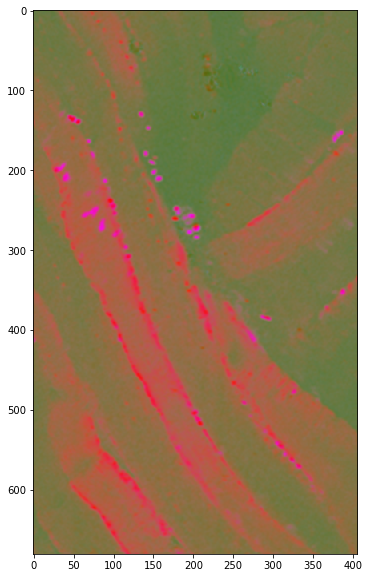

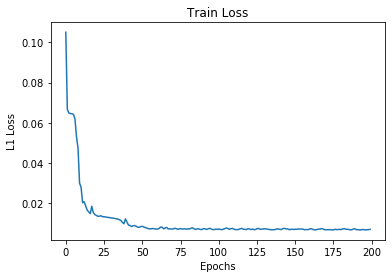

100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


In [61]:
n_epochs = 200
L1_loss = []
z_imgs = []

for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images in img_stack:
        images = images[None, :]
        image_x_p = torch.permute(images, (0, 3, 1, 2))
        image_x_p = image_x_p.to(device)
        optimizer.zero_grad()         
        #outputs = model(image_x_p)
        z = model.forward_enc(image_x_p)
        outputs = model.forward_dec(z)
        
        # reconstruction loss
        loss_recon = criterion(outputs, image_x_p)
        
        # variance-ordering loss
        msq0 = meansq(z[:,0,:,:])
        msq1 = meansq(z[:,1,:,:])
        msq2 = meansq(z[:,2,:,:])
        loss_varianceOrdering = f.relu(msq1-msq0) + f.relu(msq2-msq1)
        
        # total loss
        loss = loss_recon + loss_varianceOrdering
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image_x_p.size(0)
          
    train_loss = train_loss/len(img_stack)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    L1_loss.append(train_loss)
    
    if epoch%50 == 0:
        # visualize latent space
        temp_img = visualize_z(3)
        z_imgs.append(temp_img)
        # plot loss curve
        plt.plot(L1_loss)
        plt.title('Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('L1 Loss')
        plt.show()

# Analyze latent space images

In [ ]:
z_imgs = np.asarray(z_imgs)
print(z_imgs.shape)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(z_imgs[39,:,:,:])
plt.show()

In [ ]:
# iterate through the latent space image stack and save the images
n_count = 0
for img in z_imgs:
    io.imsave('img' + str(n_count) + '.png', img)
    n_count = n_count + 1

In [ ]:
# use the saved latent space images to create a movie
image_folder = '/home/arya1080/python_projects/CNN_TAM'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()